## Лабораторная работа №1. Бинарная классификация фактографических данных

**Выполнил:** Китайский А.С.

**Проверил:** Мохов А.С.

**Цель работы:**

Получить практические навыки решения задачи бинарной классификации данных в среде Jupyter Notebook. Научиться загружать данные, обучать классификаторы и проводить классификацию. Научиться оценивать точность полученных моделей.

#### 1. Импорт необходимых модулей

In [309]:
# библиотека для работы с массивами
import numpy as np 
# библиотека для построения графиков
import matplotlib.pyplot as plt
# библиотека для построения результирующей таблицы
import pandas as pd

# Требуемые модули из sklearn
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#### 2. Загрузка данных
   
| Вариант     | 8     |
|-------------|-------|
| random_state| 15    |
| Вид классов | moons |
| noise       | 0.2   | 

Объем выборки n_samples = 1000 объектов.

In [310]:
X, y = make_moons(n_samples = 1000, random_state = 15, noise = 0.2)

#### 3. Выведем первые 15 элементов выборки

In [311]:
print ("Координаты точек: ") 
print (X[:15])
print ("Метки класса: ") 
print (y[:15])

Координаты точек: 
[[ 1.7271961  -0.39285757]
 [-0.91801735  0.81910014]
 [-0.91532959 -0.05460812]
 [ 0.14537408  0.2064726 ]
 [ 0.95552152  0.20921022]
 [ 1.85825106 -0.35738814]
 [ 0.0761107   0.90867532]
 [-0.66311624  1.08115035]
 [ 0.13798809  0.98723143]
 [ 1.85704117  0.34111441]
 [ 0.17994761  0.15344022]
 [ 0.91666297  0.49152481]
 [ 1.25585707 -0.50035284]
 [ 1.11412853 -0.36151518]
 [-0.41601705  0.82276341]]
Метки класса: 
[1 0 0 1 0 1 0 0 0 1 1 0 1 1 0]


#### 4. Отобразим на графике сгенерированную выборку

<function matplotlib.pyplot.show(close=None, block=None)>

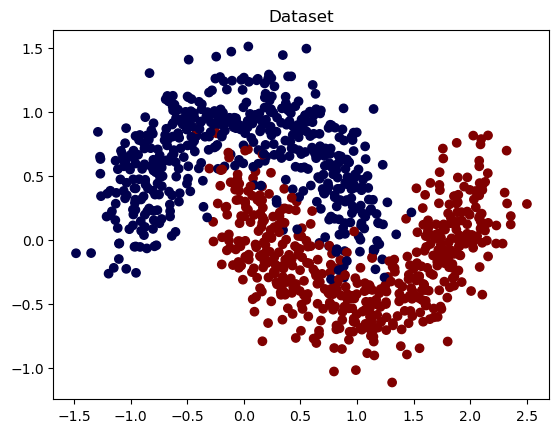

In [312]:
plt.scatter(X[:,0], X[:,1], cmap='seismic', c=y)
plt.title("Dataset")
plt.show

#### 5. Разобьем данные на обучающую (train) и тестовую (test) выборки

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

#### 6. Отобразим на графике обучающую и тестовую выборки

<bound method Figure.show of <Figure size 1200x500 with 2 Axes>>

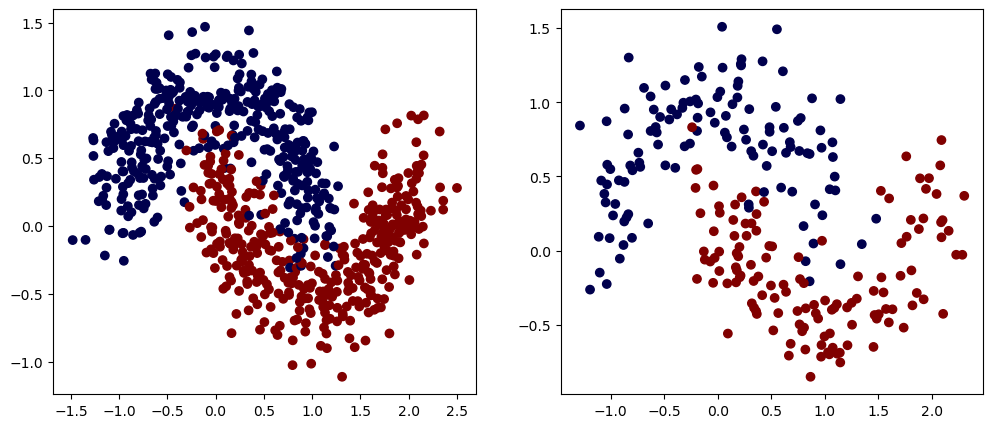

In [385]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(X_train[:,0], X_train[:,1], cmap='seismic', c=y_train)
ax[1].scatter(X_test[:,0], X_test[:,1], cmap='seismic', c=y_test)
fig.show

#### 7. Реализуем модели классификаторов и обучим их на обучающем множестве. Применим модели на тестовой выборке, выведем результаты классификации

Функция для наглядного отображения на графике область принятия решений по каждому классу

In [386]:
def plot_2d_separator(classifier, X, fill=False, line=True, ax=None, eps=None):
    if eps is None:
        eps = 1.0 #X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)
    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]
        if ax is None:
            ax = plt.gca()
        if fill:
            ax.contourf(X1, X2, decision_values.reshape(X1.shape),
            levels=fill_levels, colors=['cyan', 'pink', 'yellow'])
        if line:
            ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels, colors="black")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())

In [387]:
def print_score(prediction):
    print('Prediction and test: ')
    print(prediction[:10])
    print(y_test[:10])

    print ('Confusion matrix: ')
    print (confusion_matrix(y_test, prediction))

    accuracy = accuracy_score(prediction, y_test)
    print ('Accuracy score: ', accuracy)
    
    report = classification_report(y_test, prediction)
    print(report)

    roc_auc = round(roc_auc_score(y_test, prediction), 3)
    print('Roc-auc: ')
    print(roc_auc)

    results = [float(i) for i in report.split()[-4:-1]]
    results.extend([accuracy, roc_auc])

    return results

In [388]:
columns = ['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc_score']
index = ['knn_n1', 'knn_n3', 'knn_n9', 'gnb', 'rfc_n5', 'rfc_n15', 'rfc_n50']

df = pd.DataFrame(columns=columns, index=index)

##### Метод к-ближайших соседей (`n_neighbors` = {1, 3, 9})

In [389]:
knn_n1 = KNeighborsClassifier(n_neighbors=1, metric = 'euclidean')
knn_n1.fit(X_train, y_train)
pred_knn_n1 = knn_n1.predict(X_test)

d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [390]:
results = print_score(pred_knn_n1)
df.loc['knn_n1'] = results

Prediction and test: 
[0 0 1 0 0 0 1 0 1 1]
[0 0 1 0 0 0 1 0 1 1]
Confusion matrix: 
[[115   6]
 [  9 120]]
Accuracy score:  0.94
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       121
           1       0.95      0.93      0.94       129

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250

Roc-auc: 
0.94


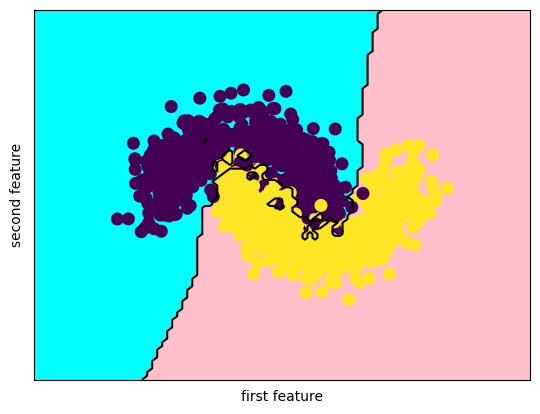

In [391]:
plt.xlabel("first feature")
plt.ylabel("second feature")
plot_2d_separator(knn_n1, X, fill=True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70)

In [392]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric = 'euclidean')
knn_n3.fit(X_train, y_train)
pred_knn_n3 = knn_n3.predict(X_test)

d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [393]:
results = print_score(pred_knn_n3)
df.loc['knn_n3'] = results

Prediction and test: 
[0 0 1 0 0 0 1 0 1 1]
[0 0 1 0 0 0 1 0 1 1]
Confusion matrix: 
[[117   4]
 [  6 123]]
Accuracy score:  0.96
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       121
           1       0.97      0.95      0.96       129

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250

Roc-auc: 
0.96


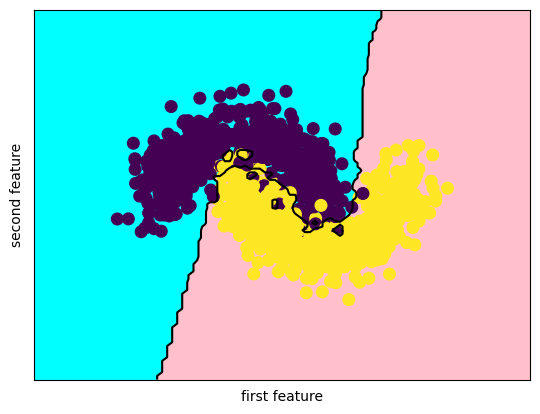

In [394]:
plt.xlabel("first feature")
plt.ylabel("second feature")
plot_2d_separator(knn_n3, X, fill=True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70)

In [395]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric = 'euclidean')
knn_n9.fit(X_train, y_train)
pred_knn_n9 = knn_n9.predict(X_test)

d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [396]:
results = print_score(pred_knn_n9)
df.loc['knn_n9'] = results

Prediction and test: 
[0 0 1 0 0 0 1 0 1 1]
[0 0 1 0 0 0 1 0 1 1]
Confusion matrix: 
[[116   5]
 [  3 126]]
Accuracy score:  0.968
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       121
           1       0.96      0.98      0.97       129

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250

Roc-auc: 
0.968


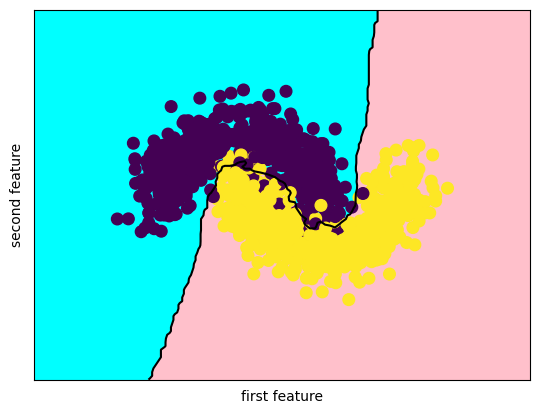

In [397]:
plt.xlabel("first feature")
plt.ylabel("second feature")
plot_2d_separator(knn_n9, X, fill=True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70)

##### Наивный байесовский метод

In [398]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred_gnb = gnb.predict(X_test)

In [399]:
results = print_score(pred_gnb)
df.loc['gnb'] = results

Prediction and test: 
[0 0 1 0 0 0 1 0 1 1]
[0 0 1 0 0 0 1 0 1 1]
Confusion matrix: 
[[110  11]
 [ 19 110]]
Accuracy score:  0.88
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       121
           1       0.91      0.85      0.88       129

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250

Roc-auc: 
0.881


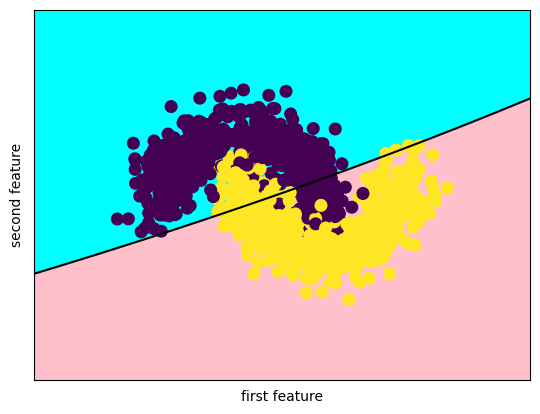

In [400]:
plt.xlabel("first feature")
plt.ylabel("second feature")
plot_2d_separator(gnb, X, fill=True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70)

##### Случайный лес (`n_estimators` = {5, 15, 50})

In [401]:
rfc_n5 = RandomForestClassifier(n_estimators=5)
rfc_n5.fit(X_train, y_train)
pred_rfc_n5 = rfc_n5.predict(X_test)

In [402]:
results = print_score(pred_gnb)
df.loc['rfc_n5'] = results

Prediction and test: 
[0 0 1 0 0 0 1 0 1 1]
[0 0 1 0 0 0 1 0 1 1]
Confusion matrix: 
[[110  11]
 [ 19 110]]
Accuracy score:  0.88
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       121
           1       0.91      0.85      0.88       129

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250

Roc-auc: 
0.881


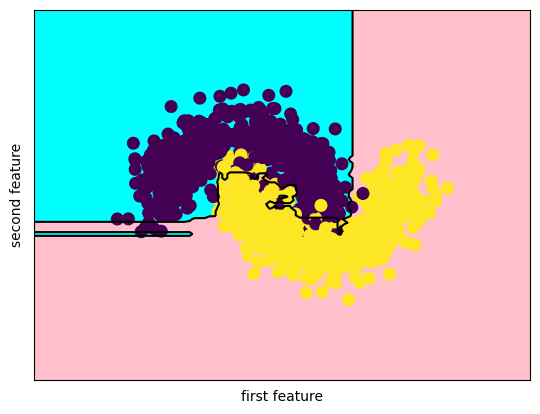

In [403]:
plt.xlabel("first feature")
plt.ylabel("second feature")
plot_2d_separator(rfc_n5, X, fill=True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70)

In [404]:
rfc_n15 = RandomForestClassifier(n_estimators=15)
rfc_n15.fit(X_train, y_train)
pred_rfc_n15 = rfc_n15.predict(X_test)

In [405]:
results = print_score(pred_rfc_n15)
df.loc['rfc_n15'] = results

Prediction and test: 
[0 0 1 0 0 0 1 0 1 1]
[0 0 1 0 0 0 1 0 1 1]
Confusion matrix: 
[[117   4]
 [  6 123]]
Accuracy score:  0.96
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       121
           1       0.97      0.95      0.96       129

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250

Roc-auc: 
0.96


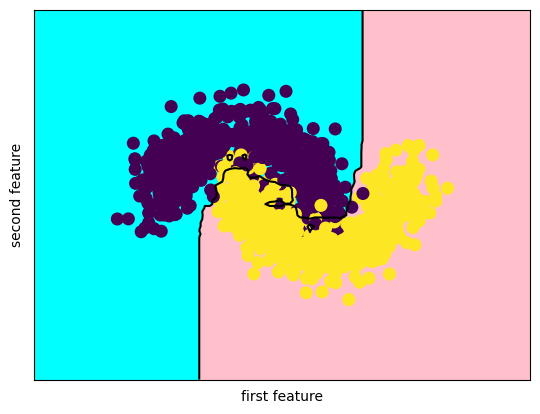

In [406]:
plt.xlabel("first feature")
plt.ylabel("second feature")
plot_2d_separator(rfc_n15, X, fill=True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70)

In [407]:
rfc_n50 = RandomForestClassifier(n_estimators=50)
rfc_n50.fit(X_train, y_train)
pred_rfc_n50 = rfc_n50.predict(X_test)

In [408]:
results = print_score(pred_rfc_n50)
df.loc['rfc_n50'] = results

Prediction and test: 
[0 0 1 0 0 0 1 0 1 1]
[0 0 1 0 0 0 1 0 1 1]
Confusion matrix: 
[[116   5]
 [  7 122]]
Accuracy score:  0.952
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       121
           1       0.96      0.95      0.95       129

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Roc-auc: 
0.952


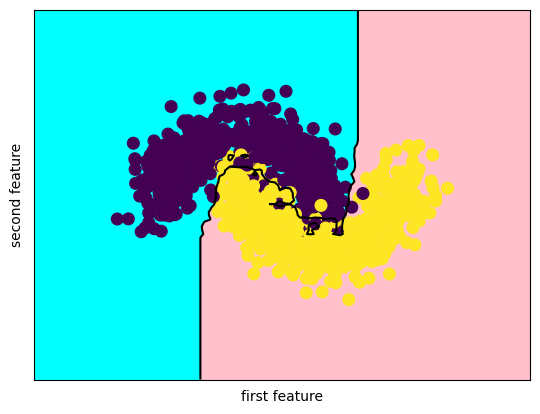

In [409]:
plt.xlabel("first feature")
plt.ylabel("second feature")
plot_2d_separator(rfc_n50, X, fill=True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70)

#### 8. Таблица с результами классификации всеми методами

In [410]:
df

,precision,recall,f1-score,accuracy,roc_auc_score
knn_n1,0.94,0.94,0.94,0.94,0.94
knn_n3,0.96,0.96,0.96,0.96,0.96
knn_n9,0.97,0.97,0.97,0.968,0.968
gnb,0.88,0.88,0.88,0.88,0.881
rfc_n5,0.88,0.88,0.88,0.88,0.881
rfc_n15,0.96,0.96,0.96,0.96,0.96
rfc_n50,0.95,0.95,0.95,0.952,0.952


#### 9. Изучим, как изменится качество классификации в случае другого разбиения выборки на обучающую и тестовую. Для этого повторим пункты 5, передав в параметр random_state новое значение, и пункты 7-8 дважды.

#### random_state = 30

In [411]:
df_rs30 = pd.DataFrame(columns=columns, index=index)

In [412]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 30)

##### Метод к-ближайших соседей (`n_neighbors` = {1, 3, 9})

In [413]:
knn_n1 = KNeighborsClassifier(n_neighbors=1, metric = 'euclidean')
knn_n1.fit(X_train, y_train)
pred_knn_n1 = knn_n1.predict(X_test)

results = print_score(pred_knn_n1)
df_rs30.loc['knn_n1'] = results

Prediction and test: 
[0 1 1 0 0 0 1 0 0 0]
[0 1 1 0 0 0 1 0 0 0]
Confusion matrix: 
[[110   6]
 [  9 125]]
Accuracy score:  0.94
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       116
           1       0.95      0.93      0.94       134

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250

Roc-auc: 
0.941


d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [414]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric = 'euclidean')
knn_n3.fit(X_train, y_train)
pred_knn_n3 = knn_n3.predict(X_test)

results = print_score(pred_knn_n3)
df_rs30.loc['knn_n3'] = results

Prediction and test: 
[0 1 1 0 0 0 1 0 0 0]
[0 1 1 0 0 0 1 0 0 0]
Confusion matrix: 
[[109   7]
 [  9 125]]
Accuracy score:  0.936
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       116
           1       0.95      0.93      0.94       134

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250

Roc-auc: 
0.936


d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [415]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric = 'euclidean')
knn_n9.fit(X_train, y_train)
pred_knn_n9 = knn_n9.predict(X_test)

results = print_score(pred_knn_n9)
df_rs30.loc['knn_n9'] = results

Prediction and test: 
[0 1 1 0 0 0 1 0 0 0]
[0 1 1 0 0 0 1 0 0 0]
Confusion matrix: 
[[111   5]
 [  7 127]]
Accuracy score:  0.952
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       116
           1       0.96      0.95      0.95       134

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Roc-auc: 
0.952


d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


##### Наивный байесовский метод

In [416]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred_gnb = gnb.predict(X_test)

results = print_score(pred_gnb)
df_rs30.loc['gnb'] = results

Prediction and test: 
[0 1 1 0 0 0 0 0 0 0]
[0 1 1 0 0 0 1 0 0 0]
Confusion matrix: 
[[102  14]
 [ 25 109]]
Accuracy score:  0.844
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       116
           1       0.89      0.81      0.85       134

    accuracy                           0.84       250
   macro avg       0.84      0.85      0.84       250
weighted avg       0.85      0.84      0.84       250

Roc-auc: 
0.846


##### Случайный лес (`n_estimators` = {5, 15, 50})

In [417]:
rfc_n5 = RandomForestClassifier(n_estimators=5)
rfc_n5.fit(X_train, y_train)
pred_rfc_n5 = rfc_n5.predict(X_test)

results = print_score(pred_gnb)
df_rs30.loc['rfc_n5'] = results

Prediction and test: 
[0 1 1 0 0 0 0 0 0 0]
[0 1 1 0 0 0 1 0 0 0]
Confusion matrix: 
[[102  14]
 [ 25 109]]
Accuracy score:  0.844
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       116
           1       0.89      0.81      0.85       134

    accuracy                           0.84       250
   macro avg       0.84      0.85      0.84       250
weighted avg       0.85      0.84      0.84       250

Roc-auc: 
0.846


In [418]:
rfc_n15 = RandomForestClassifier(n_estimators=15)
rfc_n15.fit(X_train, y_train)
pred_rfc_n15 = rfc_n15.predict(X_test)

results = print_score(pred_rfc_n15)
df_rs30.loc['rfc_n15'] = results

Prediction and test: 
[0 1 1 0 0 0 1 0 0 0]
[0 1 1 0 0 0 1 0 0 0]
Confusion matrix: 
[[108   8]
 [  6 128]]
Accuracy score:  0.944
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       116
           1       0.94      0.96      0.95       134

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250

Roc-auc: 
0.943


In [419]:
rfc_n50 = RandomForestClassifier(n_estimators=50)
rfc_n50.fit(X_train, y_train)
pred_rfc_n50 = rfc_n50.predict(X_test)

results = print_score(pred_rfc_n50)
df_rs30.loc['rfc_n50'] = results

Prediction and test: 
[0 1 1 0 0 0 1 0 0 0]
[0 1 1 0 0 0 1 0 0 0]
Confusion matrix: 
[[109   7]
 [  6 128]]
Accuracy score:  0.948
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       116
           1       0.95      0.96      0.95       134

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Roc-auc: 
0.947


#### random_state = 60

In [420]:
df_rs60 = pd.DataFrame(columns=columns, index=index)

In [421]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 60)

##### Метод к-ближайших соседей (`n_neighbors` = {1, 3, 9})

In [422]:
knn_n1 = KNeighborsClassifier(n_neighbors=1, metric = 'euclidean')
knn_n1.fit(X_train, y_train)
pred_knn_n1 = knn_n1.predict(X_test)

results = print_score(pred_knn_n1)
df_rs60.loc['knn_n1'] = results

Prediction and test: 
[0 1 0 1 0 0 1 1 0 0]
[0 1 0 1 1 0 1 1 0 0]
Confusion matrix: 
[[125   8]
 [  9 108]]
Accuracy score:  0.932
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       133
           1       0.93      0.92      0.93       117

    accuracy                           0.93       250
   macro avg       0.93      0.93      0.93       250
weighted avg       0.93      0.93      0.93       250

Roc-auc: 
0.931


d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [423]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric = 'euclidean')
knn_n3.fit(X_train, y_train)
pred_knn_n3 = knn_n3.predict(X_test)

results = print_score(pred_knn_n3)
df_rs60.loc['knn_n3'] = results

Prediction and test: 
[0 1 0 1 1 0 1 1 0 0]
[0 1 0 1 1 0 1 1 0 0]
Confusion matrix: 
[[124   9]
 [  5 112]]
Accuracy score:  0.944
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       133
           1       0.93      0.96      0.94       117

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250

Roc-auc: 
0.945


d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [424]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric = 'euclidean')
knn_n9.fit(X_train, y_train)
pred_knn_n9 = knn_n9.predict(X_test)

results = print_score(pred_knn_n9)
df_rs60.loc['knn_n9'] = results

Prediction and test: 
[0 1 0 1 1 0 1 1 0 0]
[0 1 0 1 1 0 1 1 0 0]
Confusion matrix: 
[[123  10]
 [  3 114]]
Accuracy score:  0.948
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       133
           1       0.92      0.97      0.95       117

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Roc-auc: 
0.95


d:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


##### Наивный байесовский метод

In [425]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred_gnb = gnb.predict(X_test)

results = print_score(pred_gnb)
df_rs60.loc['gnb'] = results

Prediction and test: 
[0 1 0 1 0 0 0 1 0 0]
[0 1 0 1 1 0 1 1 0 0]
Confusion matrix: 
[[116  17]
 [ 21  96]]
Accuracy score:  0.848
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       133
           1       0.85      0.82      0.83       117

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250

Roc-auc: 
0.846


##### Случайный лес (`n_estimators` = {5, 15, 50})

In [426]:
rfc_n5 = RandomForestClassifier(n_estimators=5)
rfc_n5.fit(X_train, y_train)
pred_rfc_n5 = rfc_n5.predict(X_test)

results = print_score(pred_gnb)
df_rs60.loc['rfc_n5'] = results

Prediction and test: 
[0 1 0 1 0 0 0 1 0 0]
[0 1 0 1 1 0 1 1 0 0]
Confusion matrix: 
[[116  17]
 [ 21  96]]
Accuracy score:  0.848
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       133
           1       0.85      0.82      0.83       117

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250

Roc-auc: 
0.846


In [427]:
rfc_n15 = RandomForestClassifier(n_estimators=15)
rfc_n15.fit(X_train, y_train)
pred_rfc_n15 = rfc_n15.predict(X_test)

results = print_score(pred_rfc_n15)
df_rs60.loc['rfc_n15'] = results

Prediction and test: 
[0 1 0 1 1 0 1 1 0 0]
[0 1 0 1 1 0 1 1 0 0]
Confusion matrix: 
[[126   7]
 [  5 112]]
Accuracy score:  0.952
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       133
           1       0.94      0.96      0.95       117

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Roc-auc: 
0.952


In [428]:
rfc_n50 = RandomForestClassifier(n_estimators=50)
rfc_n50.fit(X_train, y_train)
pred_rfc_n50 = rfc_n50.predict(X_test)

results = print_score(pred_rfc_n50)
df_rs60.loc['rfc_n50'] = results

Prediction and test: 
[0 1 0 1 1 0 1 1 0 0]
[0 1 0 1 1 0 1 1 0 0]
Confusion matrix: 
[[125   8]
 [  5 112]]
Accuracy score:  0.948
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       133
           1       0.93      0.96      0.95       117

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Roc-auc: 
0.949


#### 10. По результатам трех экспериментов составим итоговую таблицу о качестве классификаци каждым методом

In [475]:
df, df_rs30, df_rs60

(        precision recall f1-score accuracy roc_auc_score
 knn_n1       0.94   0.94     0.94     0.94          0.94
 knn_n3       0.96   0.96     0.96     0.96          0.96
 knn_n9       0.97   0.97     0.97    0.968         0.968
 gnb          0.88   0.88     0.88     0.88         0.881
 rfc_n5       0.88   0.88     0.88     0.88         0.881
 rfc_n15      0.96   0.96     0.96     0.96          0.96
 rfc_n50      0.95   0.95     0.95    0.952         0.952,
         precision recall f1-score accuracy roc_auc_score
 knn_n1       0.94   0.94     0.94     0.94         0.941
 knn_n3       0.94   0.94     0.94    0.936         0.936
 knn_n9       0.95   0.95     0.95    0.952         0.952
 gnb          0.85   0.84     0.84    0.844         0.846
 rfc_n5       0.85   0.84     0.84    0.844         0.846
 rfc_n15      0.94   0.94     0.94    0.944         0.943
 rfc_n50      0.95   0.95     0.95    0.948         0.947,
         precision recall f1-score accuracy roc_auc_score
 knn_n1     

In [476]:
df_total = pd.DataFrame(columns=columns, index=index)

In [478]:
for i in range(len(index)):
    for j in range(len(columns)):
        df_total.iloc[i, j] = np.mean([df.iloc[i, j], df_rs30.iloc[i, j], df_rs60.iloc[i, j]])
df_total

,precision,recall,f1-score,accuracy,roc_auc_score
knn_n1,0.936667,0.936667,0.936667,0.937333,0.937333
knn_n3,0.946667,0.946667,0.946667,0.946667,0.947
knn_n9,0.956667,0.956667,0.956667,0.956,0.956667
gnb,0.86,0.856667,0.856667,0.857333,0.857667
rfc_n5,0.86,0.856667,0.856667,0.857333,0.857667
rfc_n15,0.95,0.95,0.95,0.952,0.951667
rfc_n50,0.95,0.95,0.95,0.949333,0.949333


**Вывод:**  Таким образом, провели разбиение на обучающее и тестовое множество три раза, по разному разбивая выборку. Для каждого разбиения заново обучили модель и проверили ее на тестовом множестве. Значения метрик занесли в результирующие таблицы. Рассчитали средние значения для каждого показателя качества каждой модели по трем таблицам и занесли полученные значения в итоговую таблицу. 
Лучшим значением гиперпараметра n_neighbors метода k-ближайших соседей является 9. Значение гиперпараметра n_estimators=15 является лучшим для метода случаного леса. Сравнивая эти две модели между собой, можно заметить, что knn с n_neighbors=9 показывает качество немного лучше, но все же эти модели очень близки. Хуже всего на данной задаче работает наивный баесовский классификатор, его качество ниже, чем у других моделей.